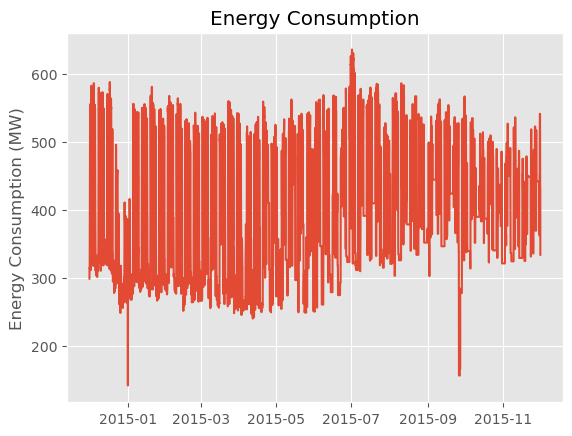

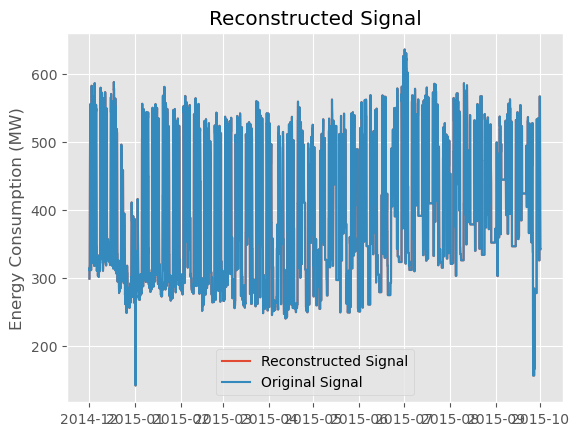

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
import pywt
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy.stats import entropy as scipy_entropy

# Set Plotting Styles
plt.style.use('ggplot')

# Read the data from CSV file
newData = pd.read_csv("Office_Garman.csv", index_col="timestamp", parse_dates=True)
# Remove duplicate entries
newData = newData.drop_duplicates()
# Set the frequency to hourly
newData = newData.asfreq('H')
# Fill missing values using forward fill method
newData = newData.fillna(method='ffill')

# Visualizing Energy Consumption Data
plt.plot(newData.index, newData['Office_Garman'])
plt.title('Energy Consumption')
plt.ylabel('Energy Consumption (MW)')
plt.show()

# Define the split date
split_date = '2015-09-30'

# Split the data into training and testing sets
train = newData.loc[:split_date]
test = newData.loc[split_date:]

# Spline interpolation
train_interpolated = train.copy()
train_interpolated['time'] = np.arange(len(train_interpolated))  # Convert index to numeric representation
for col in train_interpolated.columns:
    f = interp1d(train_interpolated['time'], train_interpolated[col], kind='cubic')
    train_interpolated[col] = f(np.arange(len(train_interpolated)))  # Interpolate values using numeric representation

# DWT decomposition
coeffs_decomposed = pywt.wavedec(train_interpolated['Office_Garman'].values, 'db4', level=5)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=3)
clusters = dbscan.fit_predict(coeffs_decomposed[0].reshape(-1, 1))

# Calculate entropy using Scipy entropy
high_freq_components = []
low_freq_components = []
entropy_values = []
for i, cluster in enumerate(clusters[:min(len(clusters), len(coeffs_decomposed)-1)]):
    if cluster == -1:
        high_freq_components.append(coeffs_decomposed[i+1])  # Adjusted index to skip the first component
    else:
        low_freq_components.append(coeffs_decomposed[i+1])  # Adjusted index to skip the first component
    entropy = scipy_entropy(coeffs_decomposed[i+1].flatten())
    entropy_values.append(entropy)

# setting the number of decomposition levels in the wavelet transform
level = 5
# setting the mask or filter to apply to the high-frequency coefficients during reconstruction
high_freq_mask = [1] * (len(coeffs_decomposed) - 1)  # Assuming all high-frequency coefficients are preserved

# Modify the high-frequency coefficients
for i in range(1, len(coeffs_decomposed)):
    coeffs_decomposed[i] = np.multiply(coeffs_decomposed[i], high_freq_mask[i-1])

# Reconstruct the signal from the modified coefficients
reconstructed_signal = pywt.waverec(coeffs_decomposed, 'db4')

# Plot the reconstructed signal
plt.plot(train_interpolated.index, reconstructed_signal, label='Reconstructed Signal')
plt.plot(train_interpolated.index, train_interpolated['Office_Garman'], label='Original Signal')
plt.title('Reconstructed Signal')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()
